## Import libraries

In [1]:
import pathlib
import isthmuslib as isli
from typing import List, Optional, Set
import pandas as pd
from loguru import logger
from tqdm.auto import tqdm

## Config

In [2]:
transactions_file: pathlib.Path = pathlib.Path("/home/bird/data_drive/monero/transactions_flattened.feather")
output_dir: pathlib.Path = pathlib.Path() / "analysis_outputs"
limit: Optional[int] = 1_000_000

## Load data

In [3]:
txns: isli.VectorMultiset = isli.VectorMultiset().read_any(transactions_file, inplace=False)
logger.info(f"Loaded {len(txns.data)} transactions")
if limit:
    txns.data = txns.data.tail(limit)
    logger.info(f"Trimmed to {len(txns.data)} transactions")

2023-06-04 20:25:41.053 | INFO     | __main__:<module>:2 - Loaded 12870955 transactions
2023-06-04 20:25:41.054 | INFO     | __main__:<module>:5 - Trimmed to 1000000 transactions


## Use analysis (drop structure)

Flatten across transactions

In [4]:
all_indices: List[int] = []
for ring_member_list in txns.data["flat_ring_members"]:
    all_indices.extend(ring_member_list)

Count uses

In [5]:
series: pd.Series = pd.Series(all_indices)
value_counts = series.value_counts()
df = value_counts.reset_index()
df.columns = ["output_index", "use_count"]
df.sort_values(by="use_count", ascending=False, inplace=True)

Review results (tabular and viz)

In [6]:
df.head()

,output_index,use_count
0,36185669,866
1,36209202,866
2,36187496,865
3,36225639,865
4,36191296,865


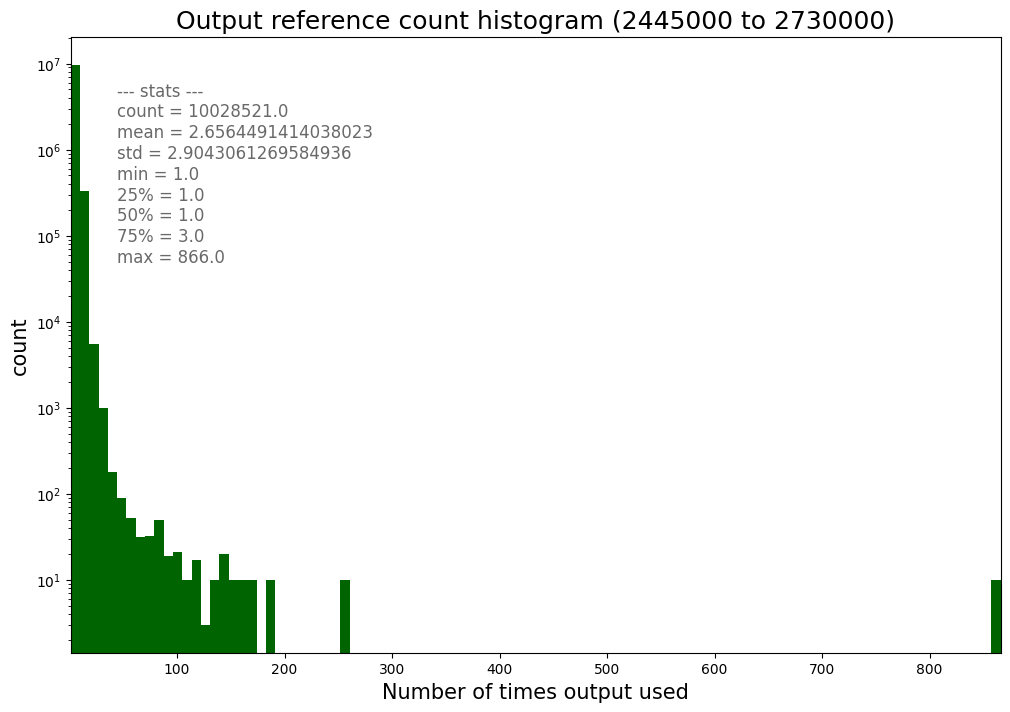

In [7]:
ring_range: str = f"{min(txns.data.block_height)} to {max(txns.data.block_height)}"
isli.hist(
    df["use_count"].tolist(),
    bins=100,
    log_axes="y",
    xlabel="Number of times output used",
    ylabel="count",
    title=f"Output reference count histogram ({ring_range})",
    describe=True,
    figsize=(12, 8),
);

## Use analysis (retain structure)

In [8]:
logger.info(f"Starting with {len(txns.data)} rows")
df_adjust = txns.data.copy()

# Explode `flat_ring_members` to create a new row for each member
logger.info(f"Exploding `flat_ring_members`")
df_adjust = df_adjust.explode("flat_ring_members")

# Group by `flat_ring_members` and aggregate `tx_hash` into lists
logger.info(f"Grouping by `flat_ring_members`")
result_df = df_adjust.groupby("flat_ring_members")["tx_hash"].agg(list).reset_index()
result_df.columns = ["output_index", "tx_hash"]

# Adding count col
logger.info(f"Adding count col")
result_df["uses"] = [len(x_) for x_ in result_df["tx_hash"]]

# Sort for convenience
logger.info(f"Sorting")
result_df.sort_values(by="uses", ascending=False, inplace=True)

# Print or return the resulting DataFrame
print(result_df)

2023-06-04 20:26:51.894 | INFO     | __main__:<module>:1 - Starting with 1000000 rows
2023-06-04 20:26:51.997 | INFO     | __main__:<module>:5 - Exploding `flat_ring_members`
2023-06-04 20:26:56.856 | INFO     | __main__:<module>:9 - Grouping by `flat_ring_members`
2023-06-04 20:30:12.772 | INFO     | __main__:<module>:14 - Adding count col
2023-06-04 20:30:15.076 | INFO     | __main__:<module>:18 - Sorting


          output_index                                            tx_hash  \
1246311       36209202  [a9380bf4318f7ddd559dcbe21cb7f2cb5e788c001239e...   
1242338       36185669  [a9380bf4318f7ddd559dcbe21cb7f2cb5e788c001239e...   
1244275       36196909  [a9380bf4318f7ddd559dcbe21cb7f2cb5e788c001239e...   
1246093       36207863  [a9380bf4318f7ddd559dcbe21cb7f2cb5e788c001239e...   
1245531       36204221  [a9380bf4318f7ddd559dcbe21cb7f2cb5e788c001239e...   
...                ...                                                ...   
3288380       41721645  [a5cba5a56d3df887a447b652e73842e32d98d983e8663...   
3288379       41721643  [09aacdfeab2d1c3f0cc2dbdc5119734f5be2db1e3b0e0...   
3288377       41721641  [2774d031faf4bd8d4ae8972eae4f5340230ab1df831db...   
3288373       41721635  [a3ba06873df9ae8e0f87307a7917b2b90c1b2057b03f1...   
10028520      62298046  [2a6420c9df8dda4673e38630183f80b526187aad4c07d...   

          uses  
1246311    866  
1242338    866  
1244275    865  
1246093

## Spot check

In [9]:
list(set(result_df["tx_hash"].iloc[0]))[:5]

['220ef9e2a89674b0c97bd78de8bf1ff39eafe00f3b54b225c218a106360d5b72',
 '6154d5020b7570ef518297feec238b7d754bf64c8cebe9c44dbce370eae726c0',
 'd93fdae123261685ef0003e76899fedede477ec90a2ccd45b0f162732e940137',
 '754d59479e3238eb37383767a6cc925c847d86cf775f940ee335481d4341f8f3',
 '6930a33d1a88ae443479ecb30687a943eefed5ee3de84f331dfa42e356fc14de']

### Save examples of dupes, ringxor style
https://xmrchain.net/search?value=79ba8cd9c8fedaeb1f23cc758235568987776fe6374da6dd28f09884c701cb50
https://xmrchain.net/search?value=b8a3530ffac558729064bd6536fe8010e87f3ed198179fb9bdec66b79b3c161d
https://xmrchain.net/search?value=32bba27641f54325d931ad73d6277a0dcf6d57983385f81688ea1223d5a5614d

## Build list of overused transactions

25 percentile: 1.0
50 percentile: 1.0
75 percentile: 3.0
90 percentile: 7.0
99 percentile: 12.0
99.9 percentile: 17.0
99.99 percentile: 30.0


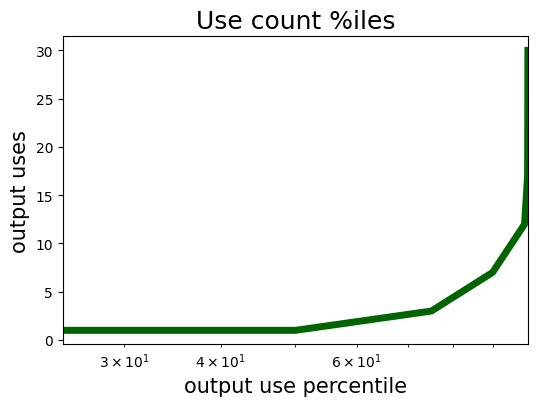

In [10]:
percentiles = [25, 50, 75, 90, 99, 99.9, 99.99]
percentile_values: List[int] = []
for percentile in percentiles:
    value = result_df["uses"].quantile(percentile / 100)
    percentile_values.append(value)
    print(f"{percentile} percentile: {value}")

isli.plot(
    percentiles,
    percentile_values,
    xlabel="output use percentile",
    ylabel="output uses",
    title="Use count %iles",
    figsize=(6, 4),
    log_axes="x",
);

## Label above certain percentile

In [11]:
max_percentile: float = 99.9
max_uses: int = result_df["uses"].quantile(max_percentile / 100)
overused_df = result_df[result_df["uses"] > max_uses]
overused_label_list: Set[str] = set()
for tx_hash_list in tqdm(overused_df["tx_hash"]):
    overused_label_list.update(tx_hash_list)
logger.info(f"{max_percentile}th percentile corresponds to {max_uses} uses")
logger.info(f"Found {len(overused_label_list)} transactions with output use count > {max_uses}")

  0%|          | 0/9573 [00:00<?, ?it/s]

2023-06-04 20:30:17.456 | INFO     | __main__:<module>:7 - 99.9th percentile corresponds to 17.0 uses
2023-06-04 20:30:17.457 | INFO     | __main__:<module>:8 - Found 96683 transactions with output use count > 17.0


Write the list out to a text file

In [12]:
output_dir.mkdir(exist_ok=True, parents=True)
with open(
    output_dir / f"overused_txns_{ring_range.replace(' ','_')}_for_{max_percentile}th_percentile.txt", "w"
) as f:
    for tx_hash in overused_label_list:
        f.write(f"{tx_hash}\n")
    logger.info(f"Wrote {len(overused_label_list)} transactions to {f.name}")

2023-06-04 20:30:17.498 | INFO     | __main__:<module>:7 - Wrote 96683 transactions to analysis_outputs/overused_txns_2445000_to_2730000_for_99.9th_percentile.txt
